# Recommendation System Project: IBM Community

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 


You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/rubrics/3325/view).  **Please save regularly.**

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

At the end of the notebook, you will find directions for how to submit your work.  Let's get started by importing the necessary libraries and reading in the data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t


df = pd.read_csv(
    'data/user-item-interactions.csv', 
    dtype={'article_id': int, 'title': str, 'email': str}
)
# Show df to get an idea of the data
df.head()

,Unnamed: 0,article_id,title,email
0,0,1430,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1,1314,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,2,1429,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,3,1338,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,4,1276,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` Are there any missing values? If so, provide a count of missing values. If there are missing values in `email`, assign it the same id value `"unknown_user"`.

In [2]:
# Some interactions do not have a user associated with it, assume the same user.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45993 entries, 0 to 45992
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  45993 non-null  int64 
 1   article_id  45993 non-null  int64 
 2   title       45993 non-null  object
 3   email       45976 non-null  object
dtypes: int64(2), object(2)
memory usage: 1.4+ MB


In [3]:
print(f"Number of Null email values is: ")

Number of Null email values is: 


In [4]:
df[df.email.isna()]

,Unnamed: 0,article_id,title,email
25131,25146,1016,why you should master r (even if it might even...,NaN
29758,30157,1393,the nurse assignment problem,NaN
29759,30158,20,working interactively with rstudio and noteboo...,NaN
29760,30159,1174,breast cancer wisconsin (diagnostic) data set,NaN
29761,30160,62,data visualization: the importance of excludin...,NaN
35264,36016,224,"using apply, sapply, lapply in r",NaN
35276,36029,961,beyond parallelize and collect,NaN
35277,36030,268,sector correlations shiny app,NaN
35278,36031,268,sector correlations shiny app,NaN
35279,36032,268,sector correlations shiny app,NaN


In [5]:
# Fill email NaNs with "unknown_user"
df['email'] = df['email'].fillna('unknown_user')

In [6]:
# Check if no more NaNs 
df[df.email.isna()]

,Unnamed: 0,article_id,title,email


`2.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.

In [7]:
# What are the descriptive statistics of the number of articles a user interacts with?
# Number of articles each user interacted with
user_article_counts = df.groupby('email')['article_id'].count()

# Descriptive statistics
user_article_counts.describe()

count    5149.000000
mean        8.932414
std        16.801011
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       364.000000
Name: article_id, dtype: float64

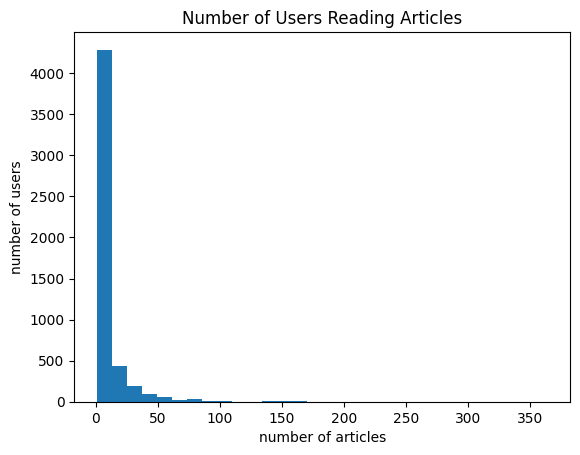

In [8]:
import matplotlib.pyplot as plt

plt.hist(user_article_counts, bins=30)
plt.xlabel('number of articles')
plt.ylabel('number of users')
plt.title('Number of Users Reading Articles')
plt.show()


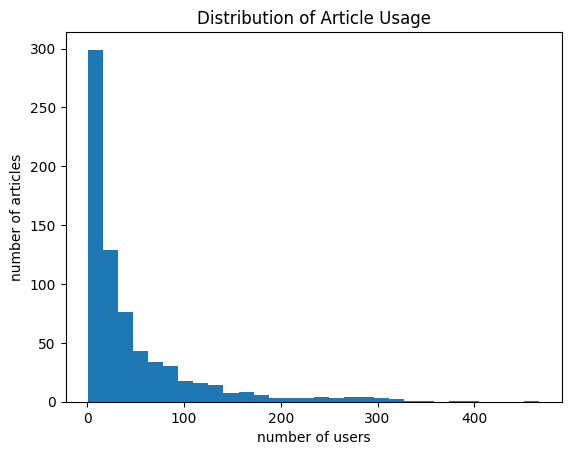

In [9]:
# Create a plot of the number of times each article was read
# Number of users per article
article_user_counts = df.groupby('article_id')['email'].nunique()

plt.hist(article_user_counts, bins=30)
plt.xlabel('number of users')
plt.ylabel('number of articles')
plt.title('Distribution of Article Usage')
plt.show()


In [10]:
# Fill in the median and maximum number of user_article interactions below

median_val = user_article_counts.median()
max_views_by_user = user_article_counts.max()


median_val, max_views_by_user

median_val = median_val  # 50% of individuals interact with this many articles or fewer
max_views_by_user = max_views_by_user  # Maximum number of user-article interactions by any user

user_article_counts = df.groupby('email')['article_id'].count()

The distribution of user interactions shows that most users interact with only a small number of articles, while a small subset of users interact with many articles. The median number of articles interacted with per user is relatively low, indicating a right-skewed distribution. A small number of highly active users account for the maximum number of interactions.

`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [11]:
# The number of unique articles that have at least one interaction
unique_articles = df['article_id'].nunique()
print(f"The number of unique articles that have at least one interaction is {unique_articles}")

# The number of unique articles on the IBM platform
total_articles = df['article_id'].nunique()
print(f"The number of unique articles on the platform is {total_articles}")

# The number of unique users
unique_users = df['email'].nunique()
print(f"The number of unique users in the dataset is {unique_users}")

# The number of user-article interactions
user_article_interactions = df.shape[0]
print(f"The number of user-article interactions in the dataset is {user_article_interactions}")

The number of unique articles that have at least one interaction is 714
The number of unique articles on the platform is 714
The number of unique users in the dataset is 5149
The number of user-article interactions in the dataset is 45993


`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [12]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper(df=df):
    coded_dict = {
        email: num 
        for num, email in enumerate(df['email'].unique(), start=1)
    }
    return [coded_dict[val] for val in df['email']]

df['user_id'] = email_mapper(df)
del df['email']

# show header
df.head()

,Unnamed: 0,article_id,title,user_id
0,0,1430,"using pixiedust for fast, flexible, and easier...",1
1,1,1314,healthcare python streaming application demo,2
2,2,1429,use deep learning for image classification,3
3,3,1338,ml optimization using cognitive assistant,4
4,4,1276,deploy your python model as a restful api,5


In [13]:
# 3. Maximum number of user-article interactions by any user
max_views_by_user = int(df.groupby('user_id').size().max())

# 4. Most viewed article and number of views
article_counts = df['article_id'].value_counts()

most_viewed_article_id = str(df['article_id'].value_counts().idxmax())

max_views = int(df['article_id'].value_counts().iloc[0])


# 5. Number of unique articles that have at least one interaction
unique_articles = int(df['article_id'].nunique())

# 6. Number of unique users in the dataset
unique_users = int(df['user_id'].nunique())

# 7. Number of unique articles on the IBM platform
total_articles = int(df['article_id'].nunique())


In [14]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

Oops! It looks like the value associated with: `The article_id of the most viewed article is ______.` wasn't right. Try again.  It might just be the datatype.  All of the values should be ints except the article_id should be a string.  Let each row be considered a separate user-article interaction.  If a user interacts with an article 3 times, these are considered 3 separate interactions.

  Notice you may also find the number of unique users as 5149 if you count the null user.  However, this is hard to catch without mapping first!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

In this project, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article. In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [15]:
def get_top_articles(n, df=df):
    """
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    """
    
    top_articles = (
        df['title']
        .value_counts()
        .index[:n]
        .tolist()
    )
    
    return top_articles


def get_top_article_ids(n, df=df):
    """
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article ids
    """
    
    top_articles = (
        df['article_id']
        .value_counts()
        .index[:n]
        .astype(str)
        .tolist()
    )
    
    return top_articles


In [16]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']
['1429', '1330', '1431', '1427', '1364', '1314', '1293', '1170', '1162', '1304']


In [17]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [18]:
def create_user_item_matrix(df):
    """
    Return a matrix with user ids as rows and article ids as columns
    with 1 where a user interacted and 0 otherwise
    """
    
    user_item = df.groupby(['user_id', 'article_id'])['title'] \
                  .count().unstack()
    
    user_item = user_item.notnull().astype(int)
    
    return user_item


user_item = create_user_item_matrix(df)

In [19]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [20]:
# Lets use the cosine_similarity function from sklearn
from sklearn.metrics.pairwise import cosine_similarity

In [21]:
def find_similar_users(user_id, user_item=user_item, df=df):
    """
    Returns users ordered by similarity,
    breaking ties by number of unique articles viewed and then user_id.
    """
    
    # Dot product similarity
    similarity = user_item.dot(user_item.loc[user_id])
    
    # Number of UNIQUE articles viewed (NO duplicates)
    num_interactions = df.groupby('user_id')['article_id'].nunique()
    
    similarity_df = pd.DataFrame({
        'similarity': similarity,
        'num_interactions': similarity.index.map(num_interactions)
    })
    
    # Remove the user itself
    similarity_df = similarity_df.drop(user_id)
    
    # Proper sorting
    similarity_df = similarity_df.sort_values(
        by=['similarity', 'num_interactions'],
        ascending=[False, False]
    )
    
    return similarity_df.index.tolist()


In [22]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 131, 3870, 46, 4201, 49]
The 5 most similar users to user 3933 are: [1, 23, 3782, 203, 4459]
The 3 most similar users to user 46 are: [4201, 23, 3782]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [23]:
def get_article_names(article_ids, df=df):
    """
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
    """
    
    article_names = []
    
    for article_id in article_ids:
        name = df[df['article_id'] == article_id]['title'].iloc[0]
        article_names.append(name)
        
    return article_names


def get_ranked_article_unique_counts(article_ids, user_item=user_item):
    """
    OUTPUT:
    ranked_article_unique_counts - (list) a list of lists:
        [[article_id, unique_user_count], ...]
    """
    
    article_counts = []
    
    for article_id in article_ids:
        count = int(user_item[article_id].sum())
        article_counts.append([article_id, count])
    
    ranked_article_unique_counts = sorted(
        article_counts,
        key=lambda x: x[1],
        reverse=True
    )
    
    return ranked_article_unique_counts




def get_user_articles(user_id, user_item=user_item):
    """
    OUTPUT:
    article_ids - list of article ids seen by the user
    article_names - list of article names seen by the user
    """
    
    article_ids = user_item.loc[user_id][user_item.loc[user_id] == 1].index.tolist()
    article_names = get_article_names(article_ids)
    
    return article_ids, article_names



def user_user_recs(user_id, m=10):
    """
    OUTPUT:
    recs - (list) a list of recommendations for the user
    """
    
    # Articles seen by the user
    user_articles, _ = get_user_articles(user_id)
    
    # Find similar users
    similar_users = find_similar_users(user_id)
    
    recs = []
    
    # Loop through similar users
    for similar_user in similar_users:
        
        # Get articles seen by similar user
        sim_articles, _ = get_user_articles(similar_user)
        
        # Find new articles not seen by the target user
        new_articles = list(set(sim_articles) - set(user_articles))
        
        # Rank new articles by popularity
        ranked_new_articles = get_ranked_article_unique_counts(new_articles)
        
        # Add articles to recommendations
        for article_id, _ in ranked_new_articles:
            if article_id not in recs:
                recs.append(article_id)
            
            if len(recs) >= m:
                return recs[:m]
    
    return recs[:m]

In [24]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['insights from new york car accident reports',
 'predicting churn with the spss random tree algorithm',
 'healthcare python streaming application demo',
 'analyze accident reports on amazon emr spark',
 'model bike sharing data with spss',
 'learn basics about notebooks and apache spark',
 'gosales transactions for logistic regression model',
 'python machine learning: scikit-learn tutorial',
 'ml optimization using cognitive assistant',
 'movie recommender system with spark machine learning']

In [25]:
get_ranked_article_unique_counts([1320, 232, 844])

[[1320, 123], [844, 78], [232, 62]]

In [26]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names([1024, 1176, 1305, 1314, 1422, 1427])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names([1320, 232, 844])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set([1320, 232, 844])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set([1024, 1176, 1305, 1314, 1422, 1427])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
assert get_ranked_article_unique_counts([1320, 232, 844])[0] == [1320, 123], "Oops! Your the get_ranked_article_unique_counts function doesn't work quite how we expect.\nMake sure you are using the user_item matrix to create the article counts."
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [27]:
from sklearn.metrics.pairwise import cosine_similarity

def get_top_sorted_users(user_id, user_item=user_item, df=df):
    
    # Target vector
    user_vector = user_item.loc[user_id].values.reshape(1, -1)
    
    similarities = []
    
    for other_user in user_item.index:
        other_vector = user_item.loc[other_user].values.reshape(1, -1)
        sim = cosine_similarity(user_vector, other_vector)[0][0]
        similarities.append(sim)
    
    neighbors_df = pd.DataFrame({
        'neighbor_id': user_item.index,
        'similarity': similarities
    })
    
    # Total interactions from df
    num_interactions = df.groupby('user_id')['article_id'].count()
    neighbors_df['num_interactions'] = neighbors_df['neighbor_id'].map(num_interactions)
    
    # Remove self
    neighbors_df = neighbors_df[neighbors_df['neighbor_id'] != user_id]
    
    # Required sorting
    neighbors_df = neighbors_df.sort_values(
        by=['similarity', 'num_interactions', 'neighbor_id'],
        ascending=[False, False, True],
        kind='mergesort'
    ).reset_index(drop=True)

    
    return neighbors_df





def user_user_recs_part2(user_id, m=10):
    """
    OUTPUT:
    recs - list of article ids
    rec_names - list of article titles
    """
    
    # Articles already seen by the user
    user_articles, _ = get_user_articles(user_id)
    
    # Get sorted neighbors
    neighbors_df = get_top_sorted_users(user_id)
    
    recs = []
    
    for neighbor_id in neighbors_df['neighbor_id']:
        
        # Articles seen by this neighbor
        neighbor_articles, _ = get_user_articles(neighbor_id)
        
        # New articles not seen by the user
        new_articles = [article for article in neighbor_articles if article not in user_articles]

        
        if len(new_articles) == 0:
            continue
        
        # Rank these articles by overall popularity
        ranked_new_articles = get_ranked_article_unique_counts(new_articles)
        
        for article_id, _ in ranked_new_articles:
            if article_id not in recs:
                recs.append(article_id)
            
            if len(recs) >= m:
                return recs[:m], get_article_names(recs[:m])
    
    return recs[:m], get_article_names(recs[:m])


In [28]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
[1185, 1162, 1165, 1293, 254, 1271, 1328, 1410, 40, 1402]

The top 10 recommendations for user 20 are the following article names:
['classify tumors with machine learning', 'analyze energy consumption in buildings', 'analyze precipitation data', 'finding optimal locations of new store using decision optimization', 'apple, ibm add machine learning to partnership with watson-core ml coupling', 'customer demographics and sales', 'income (2015): united states demographic measures', 'uci: sms spam collection', 'ensemble learning to improve machine learning results', 'uci: adult - predict income']


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [29]:
print(get_top_sorted_users(1, user_item=user_item).head(n=1))
print(get_top_sorted_users(2, user_item=user_item).head(n=10))
print(get_top_sorted_users(131, user_item=user_item).head(n=10))

   neighbor_id  similarity  num_interactions
0         3933    0.986013                45
   neighbor_id  similarity  num_interactions
0         5083    0.730297                 5
1         1890    0.577350                 5
2         1552    0.577350                 2
3         1372    0.471405                 4
4         2941    0.433013                 9
5         2360    0.408248                 5
6         1319    0.408248                 4
7         3586    0.408248                 4
8          348    0.408248                 3
9         2825    0.408248                 3
   neighbor_id  similarity  num_interactions
0         3870    0.986667               144
1          203    0.388909               160
2         4459    0.388909               158
3         3782    0.387585               363
4           40    0.384308                78
5         4932    0.384308                76
6           23    0.377647               364
7          242    0.375823               148
8         

In [30]:
user1_most_sim = get_top_sorted_users(1).iloc[0]['neighbor_id']
user2_6th_sim = get_top_sorted_users(2).iloc[5]['neighbor_id']
user131_10th_sim = get_top_sorted_users(131).iloc[9]['neighbor_id']

In [31]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 6th most similar to user 2.': user2_6th_sim,
    'The user that is the 10th most similar to user 131.': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

Oops!  Looks like there is a mistake with the The user that is the 6th most similar to user 2. key in your dictionary.  The answer should be 3586.  Try again.


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

**Your response here**

For a new user, we would not be able to use the user-user collaborative filtering functions such as find_similar_users, user_user_recs, or user_user_recs_part2, because these methods rely on past user–article interactions to compute similarity. A new user has no interaction history, so similarity scores cannot be calculated.

However, we can still use popularity-based methods, such as recommending the most popular articles overall. These recommendations can be generated using the total number of interactions per article (for example, the output of a top_articles function). This approach does not depend on user history and therefore works for new users.

A better way to make recommendations for new users would be to use a hybrid or content-based approach. For example, we could ask the user to select a few topics of interest during onboarding and recommend articles whose content (titles, keywords, or embeddings) matches those preferences. Over time, as the user interacts with articles, we could gradually transition to collaborative filtering methods, combining popularity, content similarity, and user-user recommendations to improve personalization.

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [32]:
def top_articles(n, df=df):
    """
    INPUT:
    n - (int) the number of top articles to return
    df - pandas dataframe with article_id and title
    
    OUTPUT:
    top_articles - (list) a list of the top 'n' article ids
    """
    
    top_articles = df['article_id'].value_counts().index[:n].tolist()
    
    return top_articles

In [33]:
# What would your recommendations be for this new user 0?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 

new_user_recs = top_articles(10)


In [34]:
assert set(new_user_recs) == {1314, 1429, 1293, 1427, 1162, 1364, 1304, 1170, 1431, 1330}, "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations</a>

Another method we might use to make recommendations is to recommend similar articles that are possibly related. One way we can find article relationships is by clustering text about those articles.  Let's consider content to be the article **title**, as it is the only text we have available. One point to highlight, there isn't one way to create a content based recommendation, especially considering that text information can be processed in many ways.  

`1.` Use the function bodies below to create a content based recommender function `make_content_recs`. We'll use TF-IDF to create a matrix based off article titles, and use this matrix to create clusters of related articles. You can use this function to make recommendations of new articles.

In [35]:
df.head()

,Unnamed: 0,article_id,title,user_id
0,0,1430,"using pixiedust for fast, flexible, and easier...",1
1,1,1314,healthcare python streaming application demo,2
2,2,1429,use deep learning for image classification,3
3,3,1338,ml optimization using cognitive assistant,4
4,4,1276,deploy your python model as a restful api,5


In [36]:
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import TruncatedSVD

In [37]:
# unique articles
# Get unique articles (one row per article)
df_unique_articles = df[['article_id', 'title']].drop_duplicates().reset_index(drop=True)

In [38]:
# Create a vectorizer using TfidfVectorizer and fit it to the article titles
max_features = 200
max_df = 0.75
min_df = 5

vectorizer = TfidfVectorizer(
    max_df=max_df,
    min_df=min_df,
    stop_words="english",
    max_features=max_features,
)
print("Running TF-IDF")
X_tfidf = vectorizer.fit_transform(df_unique_articles['title'])

print(f"n_samples: {X_tfidf.shape[0]}, n_features: {X_tfidf.shape[1]}")

lsa = make_pipeline(TruncatedSVD(n_components=50), Normalizer(copy=False))
X_lsa = lsa.fit_transform(X_tfidf)

explained_variance = lsa[0].explained_variance_ratio_.sum()

print(f"Explained variance of the SVD step: {explained_variance * 100:.1f}%")

Running TF-IDF
n_samples: 714, n_features: 125
Explained variance of the SVD step: 76.0%


Text(0.5, 0, 'Number of clusters')

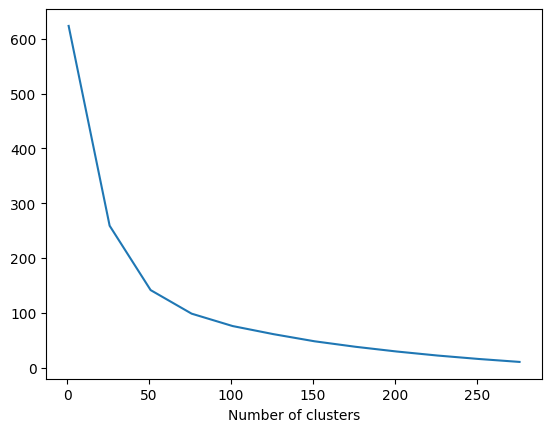

In [39]:
# Let's map the inertia for different number of clusters to find the optimal number of clusters
# We'll plot it to see the elbow
inertia = []
clusters = 300
step = 25
max_iter = 50
n_init = 5
random_state = 42
for k in range(1, clusters, step):
    kmeans = KMeans(
        n_clusters=k,
        max_iter=max_iter,
        n_init=n_init,
        random_state=random_state,
    ).fit(X_lsa)
    # inertia is the sum of squared distances to the closest cluster center
    inertia.append(kmeans.inertia_)
plt.plot(range(1, clusters, step), inertia)
plt.xlabel('Number of clusters')

There appears to be an elbow about 50, so we'll use 50 clusters.

In [40]:
# Number of clusters
n_clusters = 50

kmeans = KMeans(
    n_clusters=n_clusters,
    random_state=42
).fit(X_lsa)


In [41]:
# create a new column `title_cluster` and assign it the kmeans cluster labels
# First we need to map the labels to df_unique_articles article ids and then apply those to df
# create a new column `title_cluster` and assign it the kmeans cluster labels
# First we need to map the labels to df_unique_articles article ids and then apply those to df

article_cluster_map = dict(
    zip(df_unique_articles['article_id'], kmeans.labels_)
)

df['title_cluster'] = df['article_id'].map(article_cluster_map)

In [42]:
# Let's check the number of articles in each cluster
np.array(np.unique(kmeans.labels_, return_counts=True)).T

array([[ 0, 23],
       [ 1, 11],
       [ 2,  1],
       [ 3,  8],
       [ 4, 30],
       [ 5, 73],
       [ 6, 10],
       [ 7, 20],
       [ 8, 19],
       [ 9, 20],
       [10, 37],
       [11,  8],
       [12, 13],
       [13,  8],
       [14, 11],
       [15, 28],
       [16, 17],
       [17, 20],
       [18, 12],
       [19, 15],
       [20,  7],
       [21, 17],
       [22,  9],
       [23, 21],
       [24,  8],
       [25, 37],
       [26, 16],
       [27, 15],
       [28, 10],
       [29, 28],
       [30, 11],
       [31,  8],
       [32,  9],
       [33,  5],
       [34,  6],
       [35,  6],
       [36, 10],
       [37,  7],
       [38,  7],
       [39, 11],
       [40,  7],
       [41,  9],
       [42,  8],
       [43,  9],
       [44,  7],
       [45,  5],
       [46,  7],
       [47, 12],
       [48,  8],
       [49, 10]])

In [43]:
def get_similar_articles(article_id, df=df):
    """
    INPUT:
    article_id - (int) an article id 
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    article_ids - (list) a list of article ids that are in the same title cluster
    """
    
    # Get the cluster for the given article_id
    title_cluster = df[df['article_id'] == article_id]['title_cluster'].iloc[0]
    
    # Get all articles in the same cluster
    articles_in_cluster = df[df['title_cluster'] == title_cluster]['article_id'].unique().tolist()
    
    # Remove the input article_id
    articles_in_cluster.remove(article_id)
    
    return articles_in_cluster

In [44]:
def make_content_recs(article_id, n, df=df):
    """
    INPUT:
    article_id - (int) an article id
    n - (int) the number of recommendations you want similar to the article id
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    n_ranked_similar_articles - (list) a list of article ids that are in the same title cluster ranked
                                by popularity
    n_ranked_article_names - (list) a list of article names associated with the list of article ids
    """
    
    # 1. Get similar articles from the same cluster
    similar_articles = get_similar_articles(article_id, df)
    
    # 2. Rank similar articles by number of unique users
    ranked_similar_articles = get_ranked_article_unique_counts(similar_articles)
    
    # 3. Take top n article ids
    n_ranked_similar_articles = [article_id for article_id, _ in ranked_similar_articles[:n]]
    
    # 4. Get article names
    n_ranked_article_names = get_article_names(n_ranked_similar_articles, df)
    
    return n_ranked_similar_articles, n_ranked_article_names

In [45]:
# Test out your content recommendations given artice_id 25
rec_article_ids, rec_article_titles = make_content_recs(25, 10)
print(rec_article_ids)
print(rec_article_titles)

[1025, 101, 975, 766, 508, 547, 132, 878, 92, 693]
['data tidying in data science experience', 'how to choose a project to practice data science', 'the data science process', 'making data science a team sport', 'data science in the cloud', 'trust in data science', 'collecting data science cheat sheets', '10 data science podcasts you need to be listening to right now', '9 mistakes to avoid when starting your career in data science', 'better together: spss and data science experience']


In [46]:
assert len({1025, 593, 349, 821, 464, 29, 1042, 693, 524, 352}.intersection(set(rec_article_ids))) > 0, "Oops! Your the make_content_recs function doesn't work quite how we expect."

`2.` Now that you have put together your content-based recommendation system, use the cell below to write a summary explaining how your content based recommender works.  Do you see any possible improvements that could be made to your function? What other text data would be useful to help make better recommendations besides the article title?

**Write an explanation of your content based recommendation system here.**

The content-based recommendation system is built by analyzing the textual content of the articles, using the article titles as the main source of information. First, duplicate articles are removed so that each article is represented only once. The titles are then transformed into numerical feature vectors using TF-IDF (Term Frequency–Inverse Document Frequency), which captures the importance of words within and across titles.

To reduce dimensionality and extract latent semantic structure, Latent Semantic Analysis (LSA) is applied using Truncated Singular Value Decomposition (SVD). This step helps group articles with similar themes even if they do not share many exact words. The reduced representations are then clustered using KMeans, which assigns each article to a topic-based cluster.

To generate recommendations for a given article, the system first identifies the cluster to which the article belongs. All other articles in the same cluster are considered candidates for recommendation. These candidate articles are then ranked by their overall popularity, measured as the number of unique users who have interacted with each article. The top-ranked articles are returned as recommendations.

### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to users.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [47]:
# quick look at the matrix
user_item.head()

article_id,0,2,4,8,9,12,14,15,16,18,...,1434,1435,1436,1437,1439,1440,1441,1442,1443,1444
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


`2.` In this situation, you can use Singular Value Decomposition from [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html) on the user-item matrix.  Use the cell to perform SVD.

In [48]:
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import precision_score, recall_score, accuracy_score
# Using the full number of components which equals the number of columns
svd = TruncatedSVD(n_components=len(user_item.columns), n_iter=5, random_state=42)

u = svd.fit_transform(user_item)
v = svd.components_
s = svd.singular_values_ 
print('u', u.shape)
print('s', s.shape)
print('vt', v.shape)

u (5149, 714)
s (714,)
vt (714, 714)


### Why SVD Works for the User-Item Matrix

Singular Value Decomposition (SVD) factorizes the user-item interaction matrix into three matrices:

\[
A = U \Sigma V^T
\]

Where:
- **U** represents user latent features
- **Σ (Sigma)** contains singular values representing feature importance
- **V^T** represents item latent features

In this project, the user-item matrix is binary (1 = interaction, 0 = no interaction) and contains no missing values. This makes it suitable for SVD because:

1. SVD decomposes the interaction matrix into latent factors that capture hidden patterns in user behavior.
2. These latent features represent underlying user preferences and article characteristics.
3. It reduces dimensionality, allowing us to approximate the original matrix using fewer components.
4. This helps handle sparsity and improves computational efficiency.
5. Similarity between articles can be computed in the reduced latent space rather than the full high-dimensional space.

By reconstructing the matrix using a limited number of latent features, we approximate user preferences and enable recommendation generation without using the full original matrix.


`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain better metrics when making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how our metrics improve as we increase the number of latent features.

Text(0.5, 1.0, 'Metrics vs. Number of Latent Features')

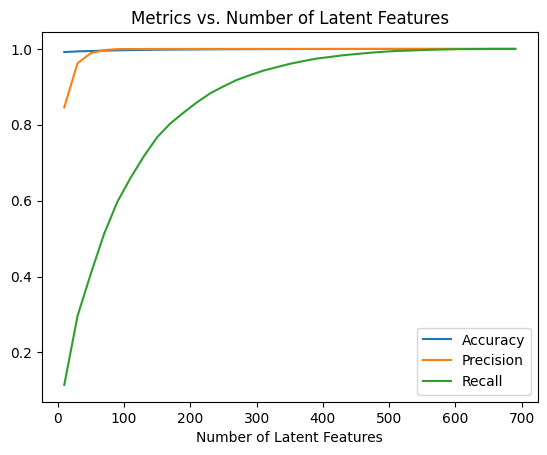

In [49]:
num_latent_feats = np.arange(10, 700+10, 20)
metric_scores = []

for k in num_latent_feats:
    # restructure with k latent features
    u_new, vt_new = u[:, :k], v[:k, :]
    
    # take dot product
    user_item_est = abs(np.around(np.dot(u_new, vt_new))).astype(int)
    # make sure the values are between 0 and 1
    user_item_est = np.clip(user_item_est, 0, 1)
    
    # total errors and keep track of them
    acc = accuracy_score(user_item.values.flatten(), user_item_est.flatten())
    precision = precision_score(user_item.values.flatten(), user_item_est.flatten())
    recall = recall_score(user_item.values.flatten(), user_item_est.flatten())
    metric_scores.append([acc, precision, recall])
    
    
plt.plot(num_latent_feats, metric_scores, label=['Accuracy', 'Precision', 'Recall'])
plt.legend()
plt.xlabel('Number of Latent Features')
plt.title('Metrics vs. Number of Latent Features')

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations. Given the plot above, what would you pick for the number of latent features and why?

**Provide your response here.**

Based on the plot, I would choose around 100 latent features.

From the figure, we can see that accuracy and precision reach very high values very quickly, while recall continues to improve as the number of latent features increases, but with diminishing returns after roughly 100 components. Beyond this point, the improvements in recall become marginal compared to the increase in model complexity.

Using a very large number of latent features (close to the total number of articles) would allow us to almost perfectly reconstruct the user–item matrix, but this does not necessarily translate into better recommendations. Instead, it increases the risk of overfitting, reduces generalization to unseen interactions, and makes the model more computationally expensive.

Therefore, selecting around 100 latent features provides a good trade-off between model performance and simplicity: the model captures the most important latent structure in the data while remaining efficient and more likely to generalize well for recommendation tasks.

`5.` Using 200 latent features and the values of U, S, and V transpose we calculated above, create an article id recommendation function that finds similar article ids to the one provide.

Create a list of 10 recommendations that are similar to article with id 4.  The function should provide these recommendations by finding articles that have the most similar latent features as the provided article.

In [50]:
def get_svd_similar_article_ids(article_id, vt, user_item=user_item, include_similarity=False):
    """
    INPUT:
    article_id - (int) an article id
    vt - (numpy array) vt matrix from SVD
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    include_similarity - (bool) whether to include the similarity in the output
    
    OUTPUT:
    article_ids - (list) a list of article ids similar using SVD factorization
    """
    
    article_idx = list(user_item.columns).index(article_id)
    
    vt_200 = vt[:200, :]

    cos_sim = cosine_similarity(vt_200.T)
    
    article_similarities = cos_sim[article_idx]
    
    similar_indices = np.argsort(article_similarities)[::-1]
    similar_indices = similar_indices[similar_indices != article_idx]
    
    most_similar_items = [user_item.columns[i] for i in similar_indices[:10]]
    
    if include_similarity:
        return [
            [user_item.columns[i], article_similarities[i]]
            for i in similar_indices[:10]
        ]
    
    return most_similar_items

In [51]:
# Create a vt_new matrix with 200 latent features
k = 200
vt_new = v[:k, :]

In [52]:
# What is the article name for article_id 4?
print("Current article:", get_article_names([4], df=df)[0])

Current article: analyze ny restaurant data using spark in dsx


In [53]:
# What are the top 10 most similar articles to article_id 4?
rec_articles = get_svd_similar_article_ids(4, vt_new, user_item=user_item)[:10]
rec_articles

[np.int64(1199),
 np.int64(1068),
 np.int64(486),
 np.int64(1202),
 np.int64(176),
 np.int64(1120),
 np.int64(244),
 np.int64(793),
 np.int64(58),
 np.int64(132)]

In [54]:
# What are the top 10 most similar articles to article_id 4?
get_article_names(rec_articles, df=df)

['country statistics: crude oil - exports',
 'airbnb data for analytics: athens reviews',
 'use spark r to load and analyze data',
 'country statistics: crude oil - proved reserves',
 'top analytics tools in 2016',
 'airbnb data for analytics: paris calendar',
 'notebooks: a power tool for data scientists',
 '10 powerful features on watson data platform, no coding necessary',
 'advancements in the spark community',
 'collecting data science cheat sheets']

In [55]:
assert set(rec_articles) == {1199, 1068, 486, 1202, 176, 1120, 244, 793, 58, 132}, "Oops! Your the get_svd_similar_article_ids function doesn't work quite how we expect."
print("That's right!  Great job!")

That's right!  Great job!


`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make above are an improvement to how users currently find articles, either by Sections 2, 3, or 4? Add any tradeoffs between each of the methods, and how you could leverage each type for different situations including new users with no history, recently new users with little history, and users with a lot of history. 

**Your response here.**

The SVD-based recommendations show that the model captures latent relationships between articles based on user behavior, rather than relying only on title similarity. The recommended articles are thematically related to analytics and data processing, which aligns well with the original article and suggests the model is learning meaningful interaction patterns.

To evaluate whether these recommendations improve the current system, A/B testing would be the most appropriate approach, comparing user engagement metrics such as click-through rate or time spent on articles across different recommendation methods. Offline metrics alone are not sufficient to assess real user value.

Each method has tradeoffs. Popularity-based recommendations work best for new users with no history. Content-based methods are suitable for users with limited interaction data but may lack diversity. Collaborative filtering and matrix factorization provide the most personalized recommendations for users with rich histories, but require sufficient interaction data. In practice, a hybrid approach combining these methods would provide the most robust and flexible recommendation system.

<a id='conclusions'></a>
### Extras
Using your workbook, you could now save your recommendations for each user, develop a class to make new predictions and update your results, and make a flask app to deploy your results.  These tasks are beyond what is required for this project.  However, from what you learned in the lessons, you certainly capable of taking these tasks on to improve upon your work here!


## Conclusion

> Congratulations!  You have reached the end of the Recommendation Systems project! 

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the [rubric](https://review.udacity.com/#!/rubrics/2322/view). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations! 